In [51]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('UNSW_2018_IoT_Botnet_Full5pc_1.csv', low_memory=False)
df2 = pd.read_csv('UNSW_2018_IoT_Botnet_Full5pc_2.csv', low_memory=False)
df3 = pd.read_csv('UNSW_2018_IoT_Botnet_Full5pc_3.csv', low_memory=False)
df4 = pd.read_csv('UNSW_2018_IoT_Botnet_Full5pc_4.csv', low_memory=False)
df = pd.concat([df1, df2, df3, df4])

In [3]:
df['attack_label'] = df['category'] + "_" + df['subcategory']
df['attack_label'] = df['attack_label'].replace({
    'Reconnaissance_OS_Fingerprint': 'OS Fingerprint',
    'Reconnaissance_Service_Scan': 'Service Scan',
    'Normal_Normal': 'Normal',
    'Theft_Data_Exfiltration': 'Data Exfiltration'
})
attack_counts = df['attack_label'].value_counts()
print("Number of samples for each attack type:")
print(attack_counts)

Number of samples for each attack type:
attack_label
DoS_UDP              1032975
DDoS_TCP              977380
DDoS_UDP              948255
DoS_TCP               615800
Service Scan           73168
OS Fingerprint         17914
DoS_HTTP                1485
DDoS_HTTP                989
Normal                   477
Theft_Keylogging          73
Data Exfiltration          6
Name: count, dtype: int64


In [4]:
columns_to_drop = [
    'pkSeqID',       # row ID 
    'stime',         # start time 
    'ltime',         # end time 
    'saddr',         # source IP 
    'sport',         # source port 
    'daddr',         # destination IP
    'dport',         # destination port 
    'seq',           
    'attack',        
    'subcategory',   
    'category',      
    'attack_label',
    'flgs'
]
x = df.drop(columns=columns_to_drop)
y = df['attack_label']

In [5]:
categorical_cols = x.select_dtypes(exclude='number').columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['proto', 'state']


In [6]:
print("proto values:")
print(x['proto'].value_counts())

print("state values:")
print(x['state'].value_counts())

proto values:
proto
udp          1996437
tcp          1662812
icmp            9052
arp              213
ipv6-icmp          8
Name: count, dtype: int64
state values:
state
INT    1996208
REQ     878697
RST     775168
URP       8950
FIN       6387
ACC       2476
CON        526
ECO         70
TST         16
MAS         16
NRS          8
Name: count, dtype: int64


In [7]:
x = pd.get_dummies(x, columns=['proto'], prefix=['proto'])
x = pd.get_dummies(x, columns=['state'], prefix=['state'])
print(x.columns.tolist())

['flgs_number', 'proto_number', 'pkts', 'bytes', 'state_number', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'proto_arp', 'proto_icmp', 'proto_ipv6-icmp', 'proto_tcp', 'proto_udp', 'state_ACC', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT', 'state_MAS', 'state_NRS', 'state_REQ', 'state_RST', 'state_TST', 'state_URP']


In [8]:
le = LabelEncoder()
y = le.fit_transform(df['attack_label'])
print("Attack Label encoding map:")
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")

Attack Label encoding map:
0: DDoS_HTTP
1: DDoS_TCP
2: DDoS_UDP
3: Data Exfiltration
4: DoS_HTTP
5: DoS_TCP
6: DoS_UDP
7: Normal
8: OS Fingerprint
9: Service Scan
10: Theft_Keylogging


In [9]:
random_forest_regressor = RandomForestRegressor(criterion='squared_error', n_estimators=100, random_state=42, n_jobs=-1)
random_forest_regressor.fit(x, y)
feature_importances = random_forest_regressor.feature_importances_
feature_scores = pd.Series(feature_importances, index=x.columns).sort_values(ascending=False)
top_7 = feature_scores.head(7)
print("Top 7 Most Important Features:")
print(top_7)

Top 7 Most Important Features:
dur             0.596245
sbytes          0.216778
rate            0.052014
stddev          0.031124
proto_number    0.023133
state_number    0.020620
sum             0.010439
dtype: float64


In [11]:
top_7_features = ['dur', 'sbytes', 'rate', 'stddev', 'proto_number', 'state_number', 'sum']
x = x[top_7_features]
x.head()

,dur,sbytes,rate,stddev,proto_number,state_number,sum
0,7.056393,650,0.992008,0.068909,1,1,0.137818
1,0.000131,60,7633.588379,0.000000,2,2,0.000131
2,7.047852,796,0.993210,0.064494,1,1,0.128988
3,7.047592,694,0.993247,0.064189,1,1,0.128378
4,7.046841,989,0.993353,0.063887,1,1,0.127774


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42) 
#stratify ensures class distribution same in train and test data as the original dataset
z_score_normalization = StandardScaler()
#compute mean and std dev from training data and apply to training for z score normalization
x_train_normalized = z_score_normalization.fit_transform(x_train) 
#use mean and std dev from training data for z score normalization of test data
x_test_normalized = z_score_normalization.transform(x_test) 

In [21]:
## K Nearest Neighbors (K = 5) (euclidean distance)
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1)
knn.fit(x_train_normalized, y_train)
knn_y_pred = knn.predict(x_test_normalized)
print("KNN Accuracy:", accuracy_score(y_test, knn_y_pred))

KNN Accuracy: 0.9936745694795592


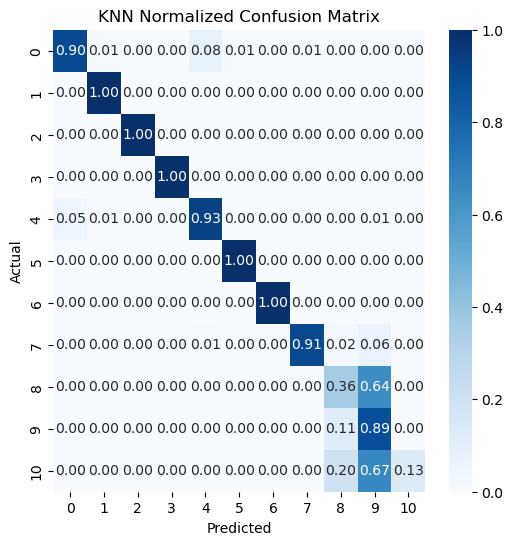

In [62]:
label_encoder = LabelEncoder().fit(y)
labels = label_encoder.classes_
knn_confusion_matrix = confusion_matrix(y_test, knn_y_pred, labels=label_encoder.transform(labels))
knn_cm_normalized = knn_confusion_matrix.astype('float') / knn_confusion_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 6))
sns.heatmap(knn_cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Normalized Confusion Matrix')
plt.show()

In [48]:
## XGBoost
xgboost = XGBClassifier(eval_metric='mlogloss', n_jobs=-1)
xgboost.fit(x_train, y_train)
xgboost_y_pred = xgboost.predict(x_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgboost_y_pred))

XGBoost Accuracy: 0.9923634158142578


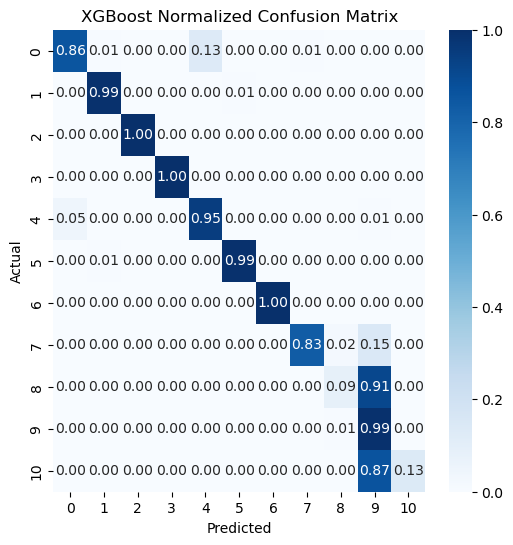

In [61]:
xgboost_confusion_matrix = confusion_matrix(y_test, xgboost_y_pred, labels=label_encoder.transform(labels))
xgboost_cm_normalized = xgboost_confusion_matrix.astype('float') / xgboost_confusion_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 6))
sns.heatmap(xgboost_cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Normalized Confusion Matrix')
plt.show()

In [31]:
## MLP
mlp = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', learning_rate_init=0.01, early_stopping=True,
                    n_iter_no_change=5, random_state=42)
mlp.fit(x_train_normalized, y_train)
mlp_y_pred = mlp.predict(x_test_normalized)
print("MLP Accuracy:", accuracy_score(y_test, mlp_y_pred))

MLP Accuracy: 0.9854314745026952


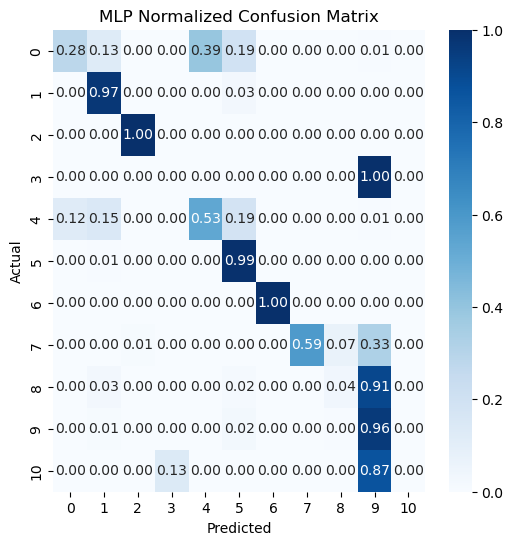

In [60]:
mlp_confusion_matrix = confusion_matrix(y_test, mlp_y_pred, labels=label_encoder.transform(labels))
mlp_cm_normalized = mlp_confusion_matrix.astype('float') / mlp_confusion_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 6))
sns.heatmap(mlp_cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MLP Normalized Confusion Matrix')
plt.show()